In [1]:
###############################################################################
# LICENSE
#Copyright (C) 2018 - INPE - NATIONAL INSTITUTE FOR SPACE RESEARCH
#This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
#This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
#You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.
###############################################################################
#======================================================================================================
# GNC-A Blog Python Tutorial: Derived Motion Winds
#======================================================================================================

# Required libraries ==================================================================================
import matplotlib.pyplot as plt                         # Import the Matplotlib package
from mpl_toolkits.basemap import Basemap                # Import the Basemap toolkit
import numpy as np                                      # Import the Numpy package
from remap_g16 import remap                                 # Import the Remap function
from cpt_convert import loadCPT                         # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap   # Linear interpolation for color maps
from datetime import datetime                           # Library to convert julian day to dd-mm-yyyy
from netCDF4 import Dataset                             # Import the NetCDF Python interface
import os                                # Miscellaneous operating system interfaces
import numpy as np                       # Import the Numpy package
import colorsys                          # To make convertion of colormaps
import matplotlib.colors as mcolors
import cartopy, cartopy.crs as ccrs  # Plot maps
import boto3                             # Amazon Web Services (AWS) SDK for Python
from botocore import UNSIGNED            # boto3 config
from botocore.config import Config       # boto3 config
import math                              # Mathematical functions
#from datetime import datetime            # Basic Dates and time types
import datetime
from osgeo import osr                    # Python bindings for GDAL
from osgeo import gdal                   # Python bindings for GDAL

#======================================================================================================

d:\RODRIGO\IntradayForecasting\Condashboard\Lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
d:\RODRIGO\IntradayForecasting\Condashboard\Lib\site-packages\osgeo\osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [2]:
def download_CMI(yyyymmddhhmn, band, path_dest, product_name):

  os.makedirs(path_dest, exist_ok=True)

  year = datetime.datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%Y')
  day_of_year = datetime.datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%j')
  hour = datetime.datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%H')
  min = datetime.datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%M')

  # AMAZON repository information
  # https://noaa-goes16.s3.amazonaws.com/index.html
  bucket_name = 'noaa-goes16'
  #product_name = 'ABI-L2-CMIPF'

  # Initializes the S3 client
  s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
  #-----------------------------------------------------------------------------------------------------------
  # File structure
  prefix = f'{product_name}/{year}/{day_of_year}/{hour}/OR_{product_name}-M6C{int(band):02.0f}_G16_s{year}{day_of_year}{hour}{min}'

  # Seach for the file on the server
  s3_result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter = "/")

  #-----------------------------------------------------------------------------------------------------------
  # Check if there are files available
  if 'Contents' not in s3_result:
    # There are no files
    print(f'No files found for the date: {yyyymmddhhmn}, Band-{band}')
    return -1
  else:
    # There are files
    for obj in s3_result['Contents']:
      key = obj['Key']
      # Print the file name
      file_name = key.split('/')[-1].split('.')[0]

      # Download the file
      if os.path.exists(f'{path_dest}/{file_name}.nc'):
        print(f'File {path_dest}/{file_name}.nc exists')
      else:
        print(f'Downloading file {path_dest}/{file_name}.nc')
        s3_client.download_file(bucket_name, key, f'{path_dest}/{file_name}.nc')
  return f'{file_name}'

def get_info(path):
    #==================================================================================================
    # Getting Information From the File Name
    #==================================================================================================
    # Search for the Scan start in the file name
    Start = (path[path.find("_s")+2:path.find("_e")])
    # Converting from julian day to dd-mm-yyyy
    year = int(Start[0:4])
    dayjulian = int(Start[4:7]) - 1 # Subtract 1 because the year starts at "0"
    dayconventional = datetime.datetime(year,1,1) + datetime.timedelta(dayjulian) # Convert from julian to conventional
    date = dayconventional.strftime('%d-%b-%Y')  # Format the date according to the strftime directives
    time = Start [7:9] + ":" + Start [9:11] + ":" + Start [11:13] + " UTC" # Time of the Start of the Scan
    # Date as string
    date_save = dayconventional.strftime('%Y%m%d')
    # Time (UTC) as string
    time_save = Start [7:9] + Start [9:11]

    #==================================================================================================
    # Detect the product type
    #==================================================================================================
    start_index = path.find("L2-") + 3
    end_index_m3 = path.find("-M3")
    end_index_m4 = path.find("-M4")
    end_index_m6 = path.find("-M6")
    # Choose the minimum index value that is not -1
    end_index = min(index for index in [end_index_m3, end_index_m4, end_index_m6] if index != -1)

    product = path[start_index:end_index]
    print(product)

    # CMIPF - Cloud and Moisture Imagery: 'CMI'
    if (product == "CMIPF") or (product == "CMIPC") or (product == "CMIPM"):
        variable = 'CMI'
        vmin = -50
        vmax = 50
        cmap = "jet"

    # ACHAF - Cloud Top Height: 'HT'
    elif product == "ACHAF":
        variable = 'HT'
        vmin = 0
        vmax = 15000
        cmap = "rainbow"

    # ACHTF - Cloud Top Temperature: 'TEMP'
    elif product == "ACHTF":
        variable = 'TEMP'
        vmin = 180
        vmax = 300
        cmap = "jet"

    # ACMF - Clear Sky Masks: 'BCM'
    elif product == "ACMF":
        variable = 'ACM'
        vmin = 0
        vmax = 1
        cmap = "gray"

    # ACTPF - Cloud Top Phase: 'Phase'
    elif product == "ACTPF":
        variable = 'Phase'
        vmin = 0
        vmax = 5
        cmap = "jet"

    # ADPF - Aerosol Detection: 'Smoke'
    elif product == "ADPF":
        variable = 'Smoke'
        vmin = 0
        vmax = 255
        cmap = "jet"

        #variable = 'Dust'
        #vmin = 0
        #vmax = 255
        #cmap = "jet"

    # AODF - Aerosol Optical Depth: 'AOD'
    elif product == "AODF":
        variable = 'AOD'
        vmin = 0
        vmax = 2
        cmap = "rainbow"

    # CODF - Cloud Optical Depth: 'COD'
    elif product == "CODF":
        variable = 'COD'
        vmin = 0
        vmax = 100
        cmap = "jet"

    # CPSF - Cloud Particle Size: 'PSD'
    elif product == "CPSF":
        variable = 'PSD'
        vmin = 0
        vmax = 80
        cmap = "rainbow"

    # CTPF - Cloud Top Pressure: 'PRES'
    elif product == "CTPF":
        variable = 'PRES'
        vmin = 0
        vmax = 1100
        cmap = "rainbow"

    # DMWF - Derived Motion Winds: 'pressure','temperature', 'wind_direction', 'wind_speed'
    elif product == "DMWF":
        variable = 'pressure'
        #variable = 'temperature'
        #variable = 'wind_direction'
        #variable = 'wind_speed'

    # DSIF - Derived Stability Indices: 'CAPE', 'KI', 'LI', 'SI', 'TT'
    elif product == "DSIF":
        variable = 'CAPE'
        vmin = 0
        vmax = 1000
        cmap = "jet"

        #variable = 'KI'
        #vmin = -50
        #vmax = 50
        #cmap = "jet"

        #variable = 'LI'
        #vmin = -10
        #vmax = 30
        #cmap = "jet"

        #variable = 'SI'
        #vmin = -10
        #vmax = 25
        #cmap = "jet"

        #variable = 'TT'
        #vmin = -10
        #vmax = 60
        #cmap = "jet"

    # DSRF - Downward Shortwave Radiation: 'DSR'
    #elif product == "DSRF":
        #    variable = 'DSR'

    # FDCF - Fire-Hot Spot Characterization: 'Area', 'Mask', 'Power', 'Temp'
    elif product == "FDCF":
        #variable = 'Area'

        variable = 'Mask'
        vmin = 0
        vmax = 255
        cmap = "jet"

        #variable = 'Power'
        #variable = 'Temp'

    # FSCF - Snow Cover: 'FSC'
    elif product == "FSCF":
        variable = 'FSC'
        vmin = 0
        vmax = 1
        cmap = "jet"

    # LSTF - Land Surface (Skin) Temperature: 'LST'
    elif product == "LSTF":
        variable = 'LST'
        vmin = 213
        vmax = 330
        cmap = "jet"

    # RRQPEF - Rainfall Rate - Quantitative Prediction Estimate: 'RRQPE'
    elif product == "RRQPEF":
        variable = 'RRQPE'
        vmin = 0
        vmax = 50
        cmap = "jet"

    # RSR - Reflected Shortwave Radiation: 'RSR'
    #elif product == "RSRF":
        #    variable = 'RSR'

    # SSTF - Sea Surface (Skin) Temperature: 'SST'
    elif product == "SSTF":
        variable = 'SST'
        vmin = 268
        vmax = 308
        cmap = "jet"

    # TPWF - Total Precipitable Water: 'TPW'
    elif product == "TPWF":
        variable = 'TPW'
        vmin = 0
        vmax = 60
        cmap = "jet"

    # VAAF - Volcanic Ash: 'VAH', 'VAML'
    elif product == "VAAF":
        #variable = 'VAH'
        #vmin = 0
        #vmax = 20000
        #cmap = "jet"

        variable = 'VAML'
        vmin = 0
        vmax = 100
        cmap = "jet"

    return product, variable, vmin, vmax, cmap, date_save, time_save

#======================================================================================================
# Remap the GOES-16 file (Returns the remapped Grid)
#======================================================================================================
def remap_g16(path, variable, extent, resolution):
    # Open the file using the NetCDF4 library
    nc = Dataset(path)

    # Get the latitude and longitude image bounds
    geo_extent = nc.variables['geospatial_lat_lon_extent']
    min_lon = float(geo_extent.geospatial_westbound_longitude)
    max_lon = float(geo_extent.geospatial_eastbound_longitude)
    min_lat = float(geo_extent.geospatial_southbound_latitude)
    max_lat = float(geo_extent.geospatial_northbound_latitude)

    # Calculate the image extent required for the reprojection
    H = nc.variables['goes_imager_projection'].perspective_point_height
    x1 = nc.variables['x_image_bounds'][0] * H
    x2 = nc.variables['x_image_bounds'][1] * H
    y1 = nc.variables['y_image_bounds'][1] * H
    y2 = nc.variables['y_image_bounds'][0] * H

    # Close the NetCDF file after getting the data
    nc.close()

    # Call the reprojection funcion
    grid = remap(path, variable, extent, resolution, x1, y1, x2, y2)

    return grid

def plot_g16(data, extent, product, variable, date_save, time_save):

    if (variable == "Dust") or (variable == "Smoke") or (variable == "TPW") or (variable == "PRES") or  (variable == "HT") or \
    (variable == "TEMP") or (variable == "AOD") or (variable == "COD") or (variable == "PSD") or  (variable == "CAPE") or  (variable == "KI") or \
    (variable == "LI") or (variable == "SI") or (variable == "TT") or (variable == "FSC") or  (variable == "RRQPE") or (variable == "VAML") or (variable == "VAH"):
        data[data == max(data[0])] = np.nan
        data[data == min(data[0])] = np.nan

    if (variable == "SST"):
        data[data == max(data[0])] = np.nan
        data[data == min(data[0])] = np.nan

        # Call the reprojection funcion again to get only the valid SST pixels
        grid = remap(path, "DQF", extent, resolution, x1, y1, x2, y2)
        data_DQF = grid.ReadAsArray()
        # If the Quality Flag is not 0, set as NaN
        data[data_DQF != 0] = np.nan

    if (variable == "Mask"):
        data[data == -99] = np.nan
        data[data == 40] = np.nan
        data[data == 50] = np.nan
        data[data == 60] = np.nan
        data[data == 150] = np.nan
        data[data == max(data[0])] = np.nan
        data[data == min(data[0])] = np.nan

    if (variable == "BCM"):
        data[data == 255] = np.nan
        data[data == 0] = np.nan

    if (variable == "ACM"):
        data[data > 3] = np.nan
        flag_values = [0, 1, 2, 3]
        flag_meanings = ['clear', 'probably_clear', 'probably_cloudy', 'cloudy']
        colors = ['blue', 'lightblue', 'lightgray', 'gray'] 
        cmap = mcolors.ListedColormap(colors[:len(flag_values)])
        data = np.ma.masked_where(~np.isin(data, flag_values), data)

    if (variable == "Phase"):
        data[data >= 5] = np.nan
        data[data == 0] = np.nan

    if (variable == "LST"):
        data[data >= 335] = np.nan
        data[data <= 200] = np.nan

    if (variable == "CMI"):
        #data[data == max(data[0])] = np.nan
        #data[data == min(data[0])] = np.nan

        # Getting information from the file name ==============================================================
        # Search for the GOES-16 channel in the file name
        index_m3c = path.find("M3C")
        index_m4c = path.find("M4C")
        index_m6c = path.find("M6C")

        # Choose the minimum index value that is not -1
        start_index = min(index for index in [index_m3c, index_m4c, index_m6c] if index != -1) + 3

        end_index = path.find("_G16")
        band = int(path[start_index:end_index])

        # Create a GOES-16 Bands string array
        Wavelenghts = ['[]','[0.47 μm]','[0.64 μm]','[0.865 μm]','[1.378 μm]','[1.61 μm]','[2.25 μm]','[3.90 μm]','[6.19 μm]','[6.95 μm]','[7.34 μm]','[8.50 μm]','[9.61 μm]','[10.35 μm]','[11.20 μm]','[12.30 μm]','[13.30 μm]']
        # Get the unit based on the channel. If channels 1 trough 6 is Albedo. If channels 7 to 16 is BT.
        if Band <= 6:
            Unit = "Reflectance"
            data = data
        else:
            Unit = "Brightness Temperature [°C]"
            # If it is an IR channel subtract 273.15 to convert to ° Celsius
            data = data - 273.15
            # Make pixels outside the footprint invisible
            data[data <= -180] = np.nan

    # Choose a title for the plot
    #Title = " GOES-16 ABI CMI Band " + str(Band) + "       " +  Wavelenghts[int(Band)] + "       " + Unit + "       " + date + "       " + time
    # Insert the institution name
    #Institution = "GNC-A Blog"

    #==================================================================================================
    # Plot the Data
    #==================================================================================================

    if (variable == "CMI"):
        if Band <= 6:
            # Converts a CPT file to be used in Python
            cpt = loadCPT('Square Root Visible Enhancement.cpt')
            # Makes a linear interpolation
            cpt_convert = LinearSegmentedColormap('cpt', cpt)
            # Plot the GOES-16 channel with the converted CPT colors (you may alter the min and max to match your preference)
            bmap.imshow(data, origin='upper', cmap=cpt_convert, vmin=0, vmax=1)
            # Insert the colorbar at the bottom
        elif Band == 7:
            # Converts a CPT file to be used in Python
            cpt = loadCPT('SVGAIR2_TEMP.cpt')
            # Makes a linear interpolation
            cpt_convert = LinearSegmentedColormap('cpt', cpt)
            # Plot the GOES-16 channel with the converted CPT colors (you may alter the min and max to match your preference)
            bmap.imshow(data, origin='upper', cmap=cpt_convert, vmin=-112.15, vmax=56.85)
            # Insert the colorbar at the bottom
        elif Band > 7 and Band < 11:
            # Converts a CPT file to be used in Python
            cpt = loadCPT('SVGAWVX_TEMP.cpt')
            # Makes a linear interpolation
            cpt_convert = LinearSegmentedColormap('cpt', cpt)
            # Plot the GOES-16 channel with the converted CPT colors (you may alter the min and max to match your preference)
            bmap.imshow(data, origin='upper', cmap=cpt_convert, vmin=-112.15, vmax=56.85)
            # Insert the colorbar at the bottom
        elif Band > 10:
            # Converts a CPT file to be used in Python
            cpt = loadCPT('IR4AVHRR6.cpt')
            # Makes a linear interpolation
            cpt_convert = LinearSegmentedColormap('cpt', cpt)
            # Plot the GOES-16 channel with the converted CPT colors (you may alter the min and max to match your preference)
            #bmap.imshow(data, origin='upper', cmap='gray', vmin=-103, vmax=84)
            bmap.imshow(data, origin='upper', cmap='gray_r', vmin=-70, vmax=40)
            # Insert the colorbar at the bottom
    elif (variable == "ACM"):
        bmap.imshow(data, cmap=cmap, origin='upper')
        # cbar = plt.colorbar(ticks=flag_values)
        # cbar.ax.set_yticklabels(flag_meanings)
        # plt.title('Four Level Cloud Mask')
    else:
        bmap.imshow(data, origin='upper', cmap=cmap, vmin=vmin, vmax=vmax)

    #cb = bmap.colorbar(location='bottom', size = '1%', pad = '-1.0%')
    #cb.outline.set_visible(False)                              # Remove the colorbar outline
    #cb.ax.tick_params(width = 0)                               # Remove the colorbar ticks
    #cb.ax.xaxis.set_tick_params(pad=-17)                     # Put the colobar labels inside the colorbar
    #cb.ax.tick_params(axis='x', colors='black', labelsize=12)  # Change the color and size of the colorbar labels

    # Save the result
    # plt.savefig('E:\\VLAB\\Python\\Output\\G16_' + product + '_' + variable + '_' + date_save + time_save + '.png', dpi=DPI, pad_inches=0)


ACMF


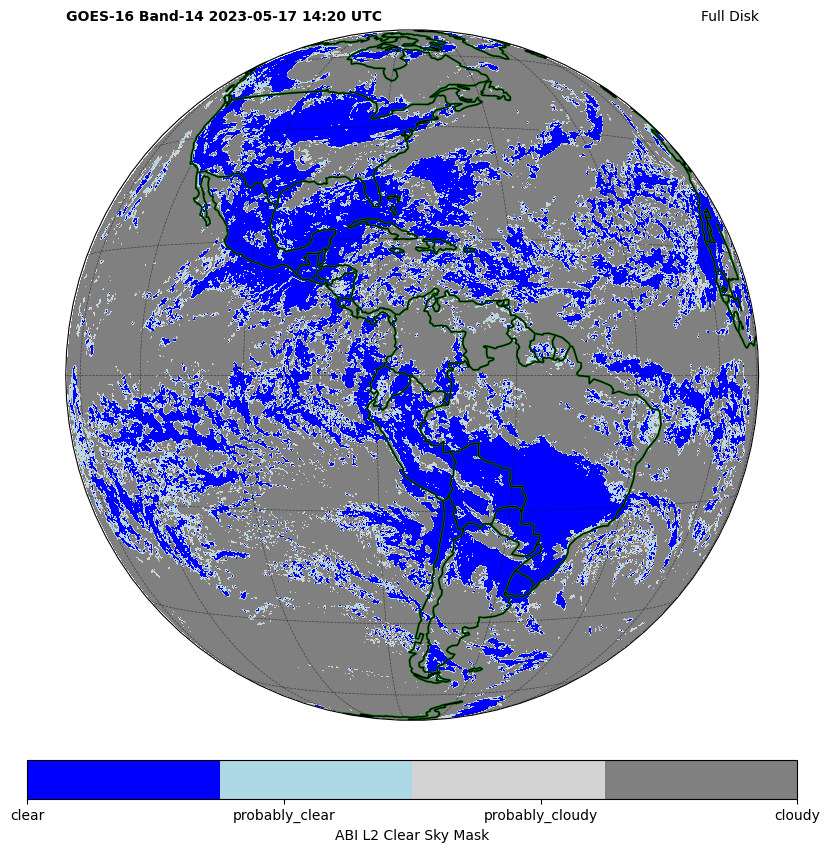

In [6]:
# path = 'content/GOES_Files/ABI_L2_ACMF/OR_ABI-L2-ACMF-M6_G16_s20231371550206_e20231371559514_c20231371600337.nc'
# path = 'content/GOES_Files/ABI_L2_ACMF/OR_ABI-L2-ACMF-M6_G16_s20231371310206_e20231371319514_c20231371320349.nc'
path = 'content/GOES_Files/ABI_L2_ACMF/OR_ABI-L2-ACMF-M6_G16_s20231371420206_e20231371429514_c20231371430318.nc'
Band = 14
product, variable, vmin, vmax, cmap, date_save, time_save = get_info(path)

x_lat = 10
x_lon = 10
plant_extent = [-73.722771-x_lon, 9.788641-x_lat, -73.722771+x_lon, 9.788641+x_lat]
extent = plant_extent
# Choose the image resolution (the higher the number the faster the processing is)
resolution = 3

file = Dataset(path)
data = file.variables['ACM'][:]
#-----------------------------------------------------------------------------------------------------------
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(10,10))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))
img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)

# Add coastlines, borders and gridlines
ax.add_feature(cartopy.feature.BORDERS, edgecolor='green', linewidth=1.6)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.8)
ax.coastlines(resolution='110m', color='green', linewidth=1.6)
ax.coastlines(resolution='110m', color='black', linewidth=0.8)
ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth=0.5)

# Define the custom colormap
flag_values = file.variables['ACM'].flag_values
flag_meanings = file.variables['ACM'].flag_meanings.split()
colors = ['blue', 'lightblue', 'lightgray', 'gray']  
cmap = mcolors.ListedColormap(colors[:len(flag_values)])
acm_data = np.ma.masked_where(~np.isin(data, flag_values), data)

# Plot the image
img = ax.imshow(acm_data, origin='upper', extent=img_extent, cmap=cmap)
cbar = plt.colorbar(img, label=file.title, orientation='horizontal', pad=0.05, fraction=0.05, ticks=flag_values)
cbar.ax.set_xticklabels(flag_meanings)

# Extract date
date = (datetime.datetime.strptime(file.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 Band-' + str(Band) + ' ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')
plt.title('Full Disk', fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
plt.show()


In [4]:
# 9.795000, -73.715000
# 9.781621, -73.729010
# extent = [-73.722451-x_lon, 9.789103-x_lat, -73.722451+x_lon, 9.789103+x_lat]
x_lon = 0.09
x_lat = 0.09
plant_extent = [-73.722771-x_lon, 9.788641-x_lat, -73.722771+x_lon, 9.788641+x_lat]
# plant_extent = [-73.7357951681, 9.774835831899999, -73.70821483190001, 9.8017851681]
print(plant_extent[1],plant_extent[0],plant_extent[3],plant_extent[2])

9.698641 -73.812771 9.878641 -73.63277099999999


ACMF
Remapping...
Remap finished! Time: 0.5272479057312012 seconds


(742, 742)

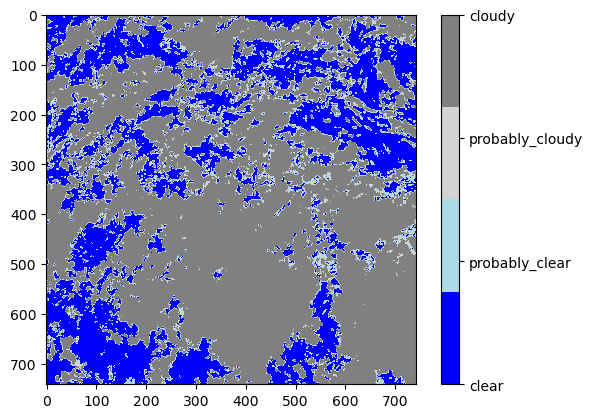

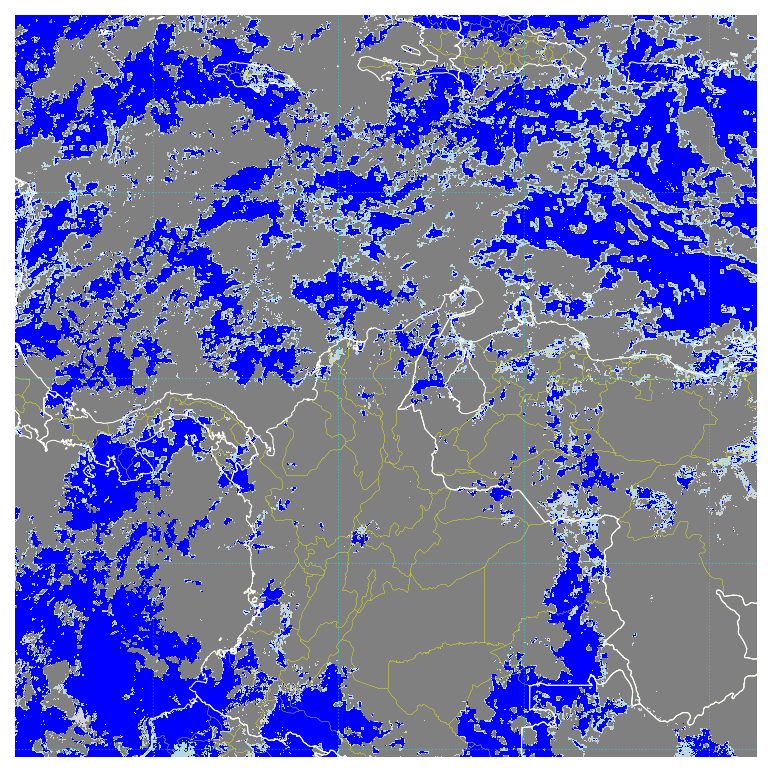

In [5]:
# path = 'content/GOES_Files/ABI_L2_ACMF/OR_ABI-L2-ACMF-M6_G16_s20231371550206_e20231371559514_c20231371600337.nc'
# path = 'content/GOES_Files/ABI_L2_ACMF/OR_ABI-L2-ACMF-M6_G16_s20231371310206_e20231371319514_c20231371320349.nc'
path = 'content/GOES_Files/ABI_L2_ACMF/OR_ABI-L2-ACMF-M6_G16_s20231371420206_e20231371429514_c20231371430318.nc'

product, variable, vmin, vmax, cmap, date_save, time_save = get_info(path)

x_lat = 10
x_lon = 10
plant_extent = [-73.722771-x_lon, 9.788641-x_lat, -73.722771+x_lon, 9.788641+x_lat]
extent = plant_extent
# Choose the image resolution (the higher the number the faster the processing is)
resolution = 3

file = Dataset(path)
data = file.variables['ACM'][:]
flag_values = file.variables['ACM'].flag_values
flag_meanings = file.variables['ACM'].flag_meanings.split()
colors = ['blue', 'lightblue', 'lightgray', 'gray']  # Example colors for each flag value
cmap = mcolors.ListedColormap(colors[:len(flag_values)])
# Mask any values that are not 0, 1, 2, or 3
acm_data = np.ma.masked_where(~np.isin(data, flag_values), data)

# Call the remap function
grid = remap_g16(path, variable, extent, resolution)
# Read the data returned by the function
data_im = grid.ReadAsArray()
# Convert from int16 to uint16
data_im = data_im.astype(np.float64)


# plt.figure(figsize=(10, 10))
# plt.imshow(data_im, origin='lower')

plt.imshow(data_im, cmap=cmap, origin='upper')
# plt.colorbar()
cbar = plt.colorbar(ticks=flag_values)
cbar.ax.set_yticklabels(flag_meanings)


DPI = 150
fig = plt.figure(figsize=(data_im.shape[1]/float(DPI), data_im.shape[0]/float(DPI)), frameon=False, dpi=DPI)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax = plt.axis('off')
# Create the basemap
bmap = Basemap(llcrnrlon=extent[0], llcrnrlat=extent[1], urcrnrlon=extent[2], urcrnrlat=extent[3], epsg=4326)
# Add a background
# bmap.bluemarble()
# Add the world states and provinces shapefile
#bmap.readshapefile('E:\\VLAB\\Python\\Shapefiles\\ne_10m_admin_1_states_provinces','ne_10m_admin_1_states_provinces',linewidth=0.10,color='yellow')
bmap.readshapefile('content/Shapefiles/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces','ne_10m_admin_1_states_provinces',linewidth=0.10,color='yellow')
# Add the countries shapefile
bmap.readshapefile('content/Shapefiles/ne_10m_admin_0_countries/ne_10m_admin_0_countries','ne_10m_admin_0_countries',linewidth=0.50,color='white')
# Add the continents shapefile
# bmap.readshapefile('content/Shapefiles/continent/World_Continents','World_Continents',linewidth=1.00,color='white')
# Draw parallels and meridians
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.2, dashes=[4, 4], color='cyan', labels=[False,False,False,False], fmt='%g', labelstyle="+/-", xoffset=-0.80, yoffset=-1.00, size=7)
bmap.drawmeridians(np.arange(0.0, 360.0, 5.0), linewidth=0.2, dashes=[4, 4], color='cyan', labels=[False,False,False,False], fmt='%g', labelstyle="+/-", xoffset=-0.80, yoffset=-1.00, size=7)

# Plot the data
plot_g16(data_im, extent, product, variable, date_save, time_save)
data_im
data_im.shape
